# Data Collection

In this notebook, we'll be cleaning up the data collected from the iphone application `Physics Toolbox Sensor Suite` which recorded the linear acceleration and angular velocity through iphone's accelerometer and gyroscope sensors at a sampling rate of 100Hz.

The goal of this is to test the data collected on the logistic regression model created in `05 WebApp.ipynb` and make accurate predictions.

There were two movements conducted in the data collection, separated into two files.
1. Walking
2. Sitting to Standing

We will begin by importing the required libraries and reading in the data.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [98]:
walking = pd.read_csv('data/collected/walking3.csv')
sit2stand = pd.read_csv('data/collected/stand.csv')

Let's take a look at the data!

In [99]:
walking.shape

(1698, 7)

In [100]:
walking.head()

,time,ax,ay,az,wx,wy,wz
0,2021-09-26 22:0:50.2560,0.24,1.21,-0.750000,-0.49,0.25,0.02
1,2021-09-26 22:0:50.2610,0.28,1.03,-0.788332,-0.46,0.18,-0.04
2,2021-09-26 22:0:50.2690,0.38,1.13,-0.790000,-0.45,0.09,-0.03
3,2021-09-26 22:0:50.2790,0.53,1.20,-0.320000,-0.41,0.04,-0.03
4,2021-09-26 22:0:50.2900,0.51,0.92,-0.220000,-0.41,0.01,-0.04


In [101]:
sit2stand.shape

(1289, 7)

In [102]:
sit2stand.head()

,time,ax,ay,az,wx,wy,wz
0,2021-09-26 22:5:14.8090,-0.19,-0.15,-1.34,0.01,0.04,0.05
1,2021-09-26 22:5:14.8150,-0.19,-0.15,-1.34,0.08,-0.07,0.06
2,2021-09-26 22:5:14.8240,-0.05,0.11,-0.09,0.08,-0.08,0.08
3,2021-09-26 22:5:14.8340,0.13,0.26,0.33,0.06,-0.06,0.12
4,2021-09-26 22:5:14.8440,0.11,0.27,0.56,0.06,-0.05,0.15


As mentioned above, our data was collected at a sampling rate of 100Hz, where the trained data was sampled at 50Hz, to convert our data to match the frequency our model was trained at, we can simply drop every other row, this will cause our data to be taken at half the frequency, which would equate to a 50Hz sampling frequency.

In [103]:
walking2 = walking.iloc[::2, :]
walking2.head()

,time,ax,ay,az,wx,wy,wz
0,2021-09-26 22:0:50.2560,0.24,1.21,-0.75,-0.49,0.25,0.02
2,2021-09-26 22:0:50.2690,0.38,1.13,-0.79,-0.45,0.09,-0.03
4,2021-09-26 22:0:50.2900,0.51,0.92,-0.22,-0.41,0.01,-0.04
6,2021-09-26 22:0:50.3090,0.62,1.13,0.38,-0.46,0.01,-0.09
8,2021-09-26 22:0:50.3300,0.52,1.02,0.31,-0.46,0.08,-0.08


In [104]:
sit2stand2 = sit2stand.iloc[::2, :]
sit2stand2.head()

,time,ax,ay,az,wx,wy,wz
0,2021-09-26 22:5:14.8090,-0.19,-0.15,-1.34,0.01,0.04,0.05
2,2021-09-26 22:5:14.8240,-0.05,0.11,-0.09,0.08,-0.08,0.08
4,2021-09-26 22:5:14.8440,0.11,0.27,0.56,0.06,-0.05,0.15
6,2021-09-26 22:5:14.8640,-0.01,-0.20,-0.43,0.21,0.09,0.21
8,2021-09-26 22:5:14.8850,-0.04,-0.30,-0.89,0.50,0.30,0.24


As you can see, our data is now sampled every other row and the frequencies match. Let's now move the columns around to match the train data structure.

To do this, we'll have to do the following for both dataframes:
- drop the time column
- change a(x,y,z) to acc_(x,y,z)
- change w(x,y,z) to gyro_(x,y,z)
- lag the data by 10 rows
- drop missing values

**Dropping the time column**

In [105]:
walking2 = walking2.drop(columns='time')
sit2stand2 = sit2stand2.drop(columns='time')

In [106]:
walking2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 1696
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ax      849 non-null    float64
 1   ay      849 non-null    float64
 2   az      849 non-null    float64
 3   wx      849 non-null    float64
 4   wy      849 non-null    float64
 5   wz      849 non-null    float64
dtypes: float64(6)
memory usage: 39.9 KB


In [107]:
sit2stand2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 1288
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ax      645 non-null    float64
 1   ay      645 non-null    float64
 2   az      645 non-null    float64
 3   wx      645 non-null    float64
 4   wy      645 non-null    float64
 5   wz      645 non-null    float64
dtypes: float64(6)
memory usage: 30.4 KB


**Renaming Columns**

- change a(x,y,z) to acc_(x,y,z)
- change w(x,y,z) to gyro_(x,y,z)

In [108]:
walking2 = walking2.rename(columns={
        'wx':'gyro_x',
        'wy':'gyro_y',
        'wz':'gyro_z',
        'ax':'acc_x',
        'ay':'acc_y',
        'az':'acc_z'})

sit2stand2 = sit2stand2.rename(columns={
        'wx':'gyro_x',
        'wy':'gyro_y',
        'wz':'gyro_z',
        'ax':'acc_x',
        'ay':'acc_y',
        'az':'acc_z'})

In [109]:
walking2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 1696
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   acc_x   849 non-null    float64
 1   acc_y   849 non-null    float64
 2   acc_z   849 non-null    float64
 3   gyro_x  849 non-null    float64
 4   gyro_y  849 non-null    float64
 5   gyro_z  849 non-null    float64
dtypes: float64(6)
memory usage: 39.9 KB


In [110]:
sit2stand2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 1288
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   acc_x   645 non-null    float64
 1   acc_y   645 non-null    float64
 2   acc_z   645 non-null    float64
 3   gyro_x  645 non-null    float64
 4   gyro_y  645 non-null    float64
 5   gyro_z  645 non-null    float64
dtypes: float64(6)
memory usage: 30.4 KB


**10 Row Lag**

In [111]:
shifted_walk_data = pd.DataFrame()
shifted_stand_data = pd.DataFrame()

for i in range(1,11):
    print(f'shift: {i}')
    walking_temp = walking2.shift(i)
    walking_temp = walking_temp.rename(columns={
        'gyro_x':f'gyro_x{i}',
        'gyro_y':f'gyro_y{i}',
        'gyro_z':f'gyro_z{i}',
        'acc_x':f'acc_x{i}',
        'acc_y':f'acc_y{i}',
        'acc_z':f'acc_z{i}',
        'activity':f'activity{i}'})
    
    sit2stand_temp = sit2stand2.shift(i)
    sit2stand_temp = sit2stand_temp.rename(columns={
        'gyro_x':f'gyro_x{i}',
        'gyro_y':f'gyro_y{i}',
        'gyro_z':f'gyro_z{i}',
        'acc_x':f'acc_x{i}',
        'acc_y':f'acc_y{i}',
        'acc_z':f'acc_z{i}',
        'activity':f'activity{i}'})

    shifted_walk_data = pd.concat((shifted_walk_data, walking_temp),axis=1)
    shifted_stand_data = pd.concat((shifted_stand_data, sit2stand_temp),axis = 1)

shift: 1
shift: 2
shift: 3
shift: 4
shift: 5
shift: 6
shift: 7
shift: 8
shift: 9
shift: 10


In [112]:
shifted_walk_data.head()

,acc_x1,acc_y1,acc_z1,gyro_x1,gyro_y1,gyro_z1,acc_x2,acc_y2,acc_z2,gyro_x2,...,acc_z9,gyro_x9,gyro_y9,gyro_z9,acc_x10,acc_y10,acc_z10,gyro_x10,gyro_y10,gyro_z10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.24,1.21,-0.75,-0.49,0.25,0.02,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.38,1.13,-0.79,-0.45,0.09,-0.03,0.24,1.21,-0.75,-0.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.51,0.92,-0.22,-0.41,0.01,-0.04,0.38,1.13,-0.79,-0.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.62,1.13,0.38,-0.46,0.01,-0.09,0.51,0.92,-0.22,-0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
shifted_stand_data.head()

,acc_x1,acc_y1,acc_z1,gyro_x1,gyro_y1,gyro_z1,acc_x2,acc_y2,acc_z2,gyro_x2,...,acc_z9,gyro_x9,gyro_y9,gyro_z9,acc_x10,acc_y10,acc_z10,gyro_x10,gyro_y10,gyro_z10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.19,-0.15,-1.34,0.01,0.04,0.05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.05,0.11,-0.09,0.08,-0.08,0.08,-0.19,-0.15,-1.34,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.11,0.27,0.56,0.06,-0.05,0.15,-0.05,0.11,-0.09,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-0.01,-0.20,-0.43,0.21,0.09,0.21,0.11,0.27,0.56,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like the data was shifted properly. We can now go ahead and concatenate the shift data with the original dataframes, then drop the missing values.

**Concatenating DF & Shifted DF**

In [114]:
walking3 = pd.concat((walking2,shifted_walk_data), axis = 1)
walking3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 1696
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   acc_x     849 non-null    float64
 1   acc_y     849 non-null    float64
 2   acc_z     849 non-null    float64
 3   gyro_x    849 non-null    float64
 4   gyro_y    849 non-null    float64
 5   gyro_z    849 non-null    float64
 6   acc_x1    848 non-null    float64
 7   acc_y1    848 non-null    float64
 8   acc_z1    848 non-null    float64
 9   gyro_x1   848 non-null    float64
 10  gyro_y1   848 non-null    float64
 11  gyro_z1   848 non-null    float64
 12  acc_x2    847 non-null    float64
 13  acc_y2    847 non-null    float64
 14  acc_z2    847 non-null    float64
 15  gyro_x2   847 non-null    float64
 16  gyro_y2   847 non-null    float64
 17  gyro_z2   847 non-null    float64
 18  acc_x3    846 non-null    float64
 19  acc_y3    846 non-null    float64
 20  acc_z3    846 non-null    float

In [115]:
sit2stand3 = pd.concat((sit2stand2,shifted_stand_data), axis = 1)
sit2stand3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 1288
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   acc_x     645 non-null    float64
 1   acc_y     645 non-null    float64
 2   acc_z     645 non-null    float64
 3   gyro_x    645 non-null    float64
 4   gyro_y    645 non-null    float64
 5   gyro_z    645 non-null    float64
 6   acc_x1    644 non-null    float64
 7   acc_y1    644 non-null    float64
 8   acc_z1    644 non-null    float64
 9   gyro_x1   644 non-null    float64
 10  gyro_y1   644 non-null    float64
 11  gyro_z1   644 non-null    float64
 12  acc_x2    643 non-null    float64
 13  acc_y2    643 non-null    float64
 14  acc_z2    643 non-null    float64
 15  gyro_x2   643 non-null    float64
 16  gyro_y2   643 non-null    float64
 17  gyro_z2   643 non-null    float64
 18  acc_x3    642 non-null    float64
 19  acc_y3    642 non-null    float64
 20  acc_z3    642 non-null    float

**Dropping NA**

In [116]:
walking4 = walking3.dropna()
walking4

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,acc_x1,acc_y1,acc_z1,gyro_x1,...,acc_z9,gyro_x9,gyro_y9,gyro_z9,acc_x10,acc_y10,acc_z10,gyro_x10,gyro_y10,gyro_z10
20,-0.17,1.20,-0.31,-0.40,0.17,-0.11,-0.18,1.24,-0.39,-0.40,...,-0.79,-0.45,0.09,-0.03,0.24,1.21,-0.75,-0.49,0.25,0.02
22,0.14,1.23,-0.14,-0.42,0.26,-0.11,-0.17,1.20,-0.31,-0.40,...,-0.22,-0.41,0.01,-0.04,0.38,1.13,-0.79,-0.45,0.09,-0.03
24,0.25,1.19,-0.23,-0.44,0.34,-0.15,0.14,1.23,-0.14,-0.42,...,0.38,-0.46,0.01,-0.09,0.51,0.92,-0.22,-0.41,0.01,-0.04
26,0.40,1.04,-0.48,-0.44,0.33,-0.17,0.25,1.19,-0.23,-0.44,...,0.31,-0.46,0.08,-0.08,0.62,1.13,0.38,-0.46,0.01,-0.09
28,0.59,0.95,-0.44,-0.49,0.31,-0.22,0.40,1.04,-0.48,-0.44,...,0.05,-0.41,0.07,-0.11,0.52,1.02,0.31,-0.46,0.08,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,0.05,-0.60,-0.05,0.51,-0.28,-0.48,-0.65,-1.53,1.31,0.49,...,3.49,0.54,-0.68,-0.67,1.07,-0.97,1.42,1.58,0.09,0.39
1690,-1.38,-1.24,-2.40,0.48,0.32,-0.53,0.05,-0.60,-0.05,0.51,...,2.30,0.61,-0.69,-0.73,-2.35,-1.20,3.49,0.54,-0.68,-0.67
1692,-0.97,-0.87,1.51,0.35,0.22,-0.61,-1.38,-1.24,-2.40,0.48,...,1.39,0.49,-0.35,-0.53,-3.07,-1.83,2.30,0.61,-0.69,-0.73
1694,-0.41,-0.73,1.70,0.28,0.18,-0.58,-0.97,-0.87,1.51,0.35,...,0.28,0.38,-0.41,-0.65,-0.06,-1.11,1.39,0.49,-0.35,-0.53


In [117]:
sit2stand4 = sit2stand3.dropna()
sit2stand4

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,acc_x1,acc_y1,acc_z1,gyro_x1,...,acc_z9,gyro_x9,gyro_y9,gyro_z9,acc_x10,acc_y10,acc_z10,gyro_x10,gyro_y10,gyro_z10
20,-0.10,0.110000,0.12,-0.04,-0.08,0.01,-0.16,0.070000,0.56,-0.05,...,-0.09,0.08,-0.08,0.08,-0.19,-0.15,-1.34,0.01,0.04,0.05
22,-0.09,-0.020000,-0.13,0.01,-0.03,0.00,-0.10,0.110000,0.12,-0.04,...,0.56,0.06,-0.05,0.15,-0.05,0.11,-0.09,0.08,-0.08,0.08
24,-0.11,0.080000,-0.10,0.03,-0.05,-0.00,-0.09,-0.020000,-0.13,0.01,...,-0.43,0.21,0.09,0.21,0.11,0.27,0.56,0.06,-0.05,0.15
26,0.21,0.180000,0.02,0.06,-0.09,0.03,-0.11,0.080000,-0.10,0.03,...,-0.89,0.50,0.30,0.24,-0.01,-0.20,-0.43,0.21,0.09,0.21
28,-0.01,0.000000,-0.07,0.07,-0.01,0.05,0.21,0.180000,0.02,0.06,...,-0.87,0.57,0.26,0.10,-0.04,-0.30,-0.89,0.50,0.30,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,0.04,-0.210000,-0.03,0.01,0.03,-0.05,0.07,-0.080000,-0.10,0.01,...,-0.07,0.04,0.04,-0.09,-0.17,-0.10,0.36,0.03,0.00,-0.09
1282,0.12,-0.059244,0.51,-0.05,-0.09,-0.04,0.04,-0.210000,-0.03,0.01,...,0.34,-0.02,0.02,-0.05,-0.26,-0.13,-0.07,0.04,0.04,-0.09
1284,0.02,-0.100000,0.61,-0.06,-0.17,0.00,0.12,-0.059244,0.51,-0.05,...,0.30,0.01,-0.00,0.03,0.10,0.00,0.34,-0.02,0.02,-0.05
1286,0.29,0.100000,0.39,-0.10,-0.21,0.03,0.02,-0.100000,0.61,-0.06,...,-0.09,0.01,0.03,0.05,0.15,0.16,0.30,0.01,-0.00,0.03


Now that our collected data is working well, we can test it on our logistic regression model created earlier in google colab.

## Logistic Regression

In [118]:
logit = joblib.load("models/logit.pkl")    
results_walk = logit.predict(walking4)

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### walking

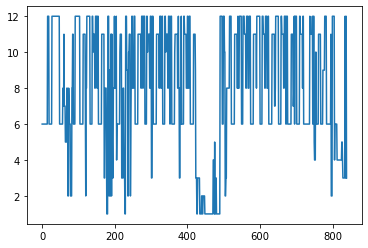

In [119]:
plt.plot(range(len(results_walk)),results_walk)

<BarContainer object of 12 artists>

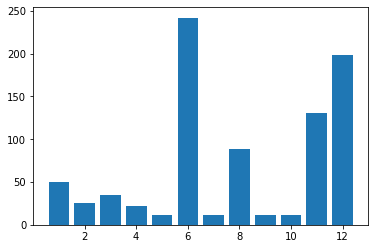

In [120]:
unique, counts = np.unique(results_walk, return_counts=True)
plt.bar(unique,counts)

### sitting

In [121]:
results_sit = logit.predict(sit2stand4)

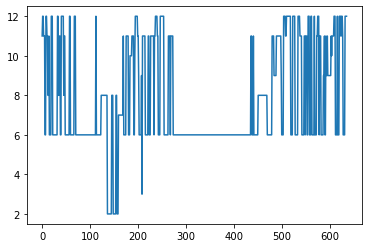

In [123]:
plt.plot(range(len(results_sit)),results_sit)

<BarContainer object of 9 artists>

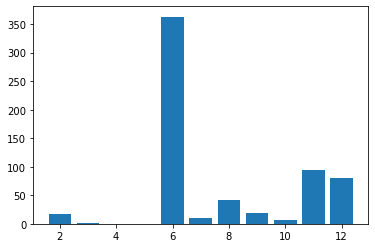

In [122]:
unique, counts = np.unique(results_sit, return_counts=True)
plt.bar(unique,counts)